# Memento-CXG cross-dataset showcase

In [1]:
import tiledb
import tiledbsoma as soma
from somacore import ExperimentAxisQuery, AxisQuery
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
import itertools
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import time
import scanpy as sc
import statsmodels.api as sm

In [2]:
import sys
sys.path.append('/home/ubuntu/Github/scrna-parameter-estimation/')
import memento

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'large',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
cube_path = '/home/ubuntu/Github/memento-cxg/'
save_path = '/home/ubuntu/results/'

### Read estimators

In [6]:
cube_path = '/home/ubuntu/Github/memento-cxg/'
save_path = '/home/ubuntu/results/'

In [7]:
all_estimators = tiledb.open(cube_path + 'estimators_cube_2').df[:]\
    .rename(columns={
    'feature_id':'cell_type',
    'cell_type':'dataset_id',
    'dataset_id':'feature_id',
})

In [8]:
def treatment_assignment(row):
    
    ct = row['cell_type']
    if 'plasma' in ct:
        return 'pdc'
    if 'conven' in ct or 'myeloid' in ct:
        return 'cdc'
    else:
        return 'unknown'

In [ ]:
all_estimators['treatment'] = all_estimators.apply(treatment_assignment, axis=1)
estimators = all_estimators.query('treatment != "unknown"').copy()

In [ ]:
donors_to_use = estimators[['cell_type', 'donor_id']].drop_duplicates().groupby('donor_id').size()
donors_to_use = donors_to_use[donors_to_use > 1].index.tolist()
# donors_to_use = ['1004',
#  '1019',]
    

estimators = estimators.query('donor_id in @donors_to_use').copy()


In [ ]:
estimators['treatment'] = estimators['treatment'].sample(frac=1)

In [ ]:
CUBE_TILEDB_DIMS_OBS = [
    "cell_type",
    "dataset_id",
]

CUBE_TILEDB_ATTRS_OBS = [
    "assay",
    "suspension_type",
    "donor_id",
    "disease",
    "sex"
]

CUBE_LOGICAL_DIMS_OBS = CUBE_TILEDB_DIMS_OBS + CUBE_TILEDB_ATTRS_OBS

DE_TREATMENT = 'treatment'
DE_COVARIATES = ['donor_id']
DE_VARIABLES = [DE_TREATMENT] + DE_COVARIATES

In [ ]:
names = estimators[DE_TREATMENT].copy()
for col in DE_COVARIATES:
    names += '_' + estimators[col]
estimators['group_name'] = names.tolist()

In [ ]:
features = estimators['feature_id'].drop_duplicates().tolist()
groups = estimators.drop_duplicates(subset='group_name').set_index('group_name')

In [ ]:
mean = estimators.pivot(index='group_name', columns='feature_id', values='mean')
se_mean = estimators.pivot(index='group_name', columns='feature_id', values='sem')
cell_counts = groups['n_obs'].sort_index().values

# Filter genes for actually expressed ones
genes_to_test = mean.columns[mean.isnull().values.mean(axis=0) < 0.1]
mean = mean[genes_to_test]
se_mean = se_mean[genes_to_test]

In [ ]:
design = pd.get_dummies(groups[DE_VARIABLES], drop_first=True).astype(int)

In [51]:
# design = design.iloc[:, :2]

### Run DE

In [52]:
def get_final_design_matrix(design):
    cov_df = design.iloc[:, 1:]
    cov_df -= cov_df.mean(axis=0)
    stim_df = design.iloc[:, [0]]
    interaction_df = cov_df*stim_df[['treatment_pdc']].values
    interaction_df.columns=[f'interaction_{col}' for col in cov_df.columns]
    cov_df = pd.concat([cov_df, interaction_df], axis=1)
    cov_df = sm.add_constant(cov_df)
    return  pd.concat([stim_df, cov_df], axis=1).values
    

In [53]:
def de_wls(X, y, n, v):
    
    from sklearn.linear_model import LinearRegression
    
    # fit WLS using sample_weights
    WLS = LinearRegression(fit_intercept=False)
    WLS.fit(X, y, sample_weight=n)
    sample_err = ((WLS.predict(X) - y)**2).mean()

    coef = WLS.coef_[0]

    W = np.diag(1/ (v) )
    beta_var_hat = np.diag(np.linalg.pinv(X.T@W@X))
    se = np.sqrt( beta_var_hat[0] )

    z = coef/se
    pv = stats.norm.sf(np.abs(z))*2
    
    return coef, z, pv

In [ ]:
def resample_donors

In [54]:
from sklearn.linear_model import LinearRegression

In [67]:
%%time
de_result = []
for feature in genes_to_test: # Can be vectorized heavily, showing for 1K genes
    
    m = mean[feature].values
    sem = se_mean[feature].values
    
    # Transform to log space (alternatively can resample in log space)
    lm = np.log(m)
    selm = (np.log(m+sem)-np.log(m-sem))/2

    sample_idxs = np.isfinite(m) & np.isfinite(sem)

    X, y, n, v = get_final_design_matrix(design.iloc[sample_idxs]), lm[sample_idxs], cell_counts[sample_idxs], selm[sample_idxs]**2
    
    # fit WLS using sample_weights
    WLS = LinearRegression(fit_intercept=False)
    WLS.fit(X, y, sample_weight=n)
    sample_err = ((WLS.predict(X) - y)**2).mean()

    coef = WLS.coef_[0]

    W = np.diag(1/ (v) )
    beta_var_hat = np.diag(np.linalg.pinv(X.T@W@X))
    se = np.sqrt( beta_var_hat[0] )

    z = coef/se
    pv = stats.norm.sf(np.abs(z))*2
    # coef, z, pv = de_wls(2)
    
    de_result.append((feature, coef, z, pv))
    
    
de_result = pd.DataFrame(de_result, columns=['feature_id','coef', 'z', 'pval']).set_index('feature_id')

CPU times: user 4.28 s, sys: 0 ns, total: 4.28 s
Wall time: 4.28 s


<Axes: >

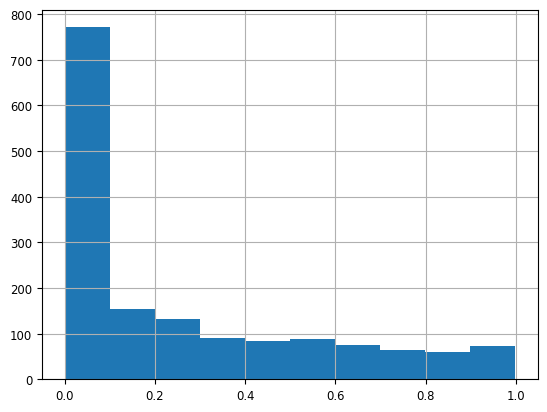

In [68]:
de_result['pval'].hist()